In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import torch
import kornia
import numpy as np
import gc
import os
import sys
%matplotlib notebook
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

from helpers import Trainer
from helpers import Logger
from helpers import Trial
from mibi_dataloader import MIBIData
from modules import Denoiser
from criteria import DenoiserLoss
from modules import Estimator
from criteria import EstimatorLoss
import utils
from scipy.ndimage import gaussian_filter

In [102]:
# Load the data
main_dir = '/home/hazmat/GitHub/Denoiser/'
train_dir = main_dir + 'data/traindat/'
test_dir = main_dir + 'data/testdat/'
leeat_dir = main_dir + 'data/Point15/TIFs/'

modl_dir = main_dir + 'models/'
rslt_dir = main_dir + 'results/'

# train_ds = MIBIData(folder=train_dir, crop=255, scale=255, stride=8)
test_ds = MIBIData(folder=test_dir, crop=255, scale=255, stride=8)
leeat_ds = MIBIData(folder=leeat_dir, crop=255, scale=255, stride=8)

Loading.......99.65277777777777%%2304
There are  2654208 samples
Loading.......98.24561403508773%2304
There are  525312 samples


In [3]:
estimator = Estimator.load_model(main_dir + 'estimator/models/estimator_saves/', 'model_10')
denoiser = Denoiser.load_model(main_dir + 'denoiser/models/2020Feb03_12-06-55/', 'model_111')
estimator.cuda()
denoiser.cuda()
print()

/home/hazmat/anaconda3/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'modules.Estimator' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [4]:
idx = 0
col = 1
for marker in leeat_ds.source:
    if col==6:
        print(marker[0:-4], ':', idx, end='\n')
        col = 0
    else:
        print(marker[0:-4], ':', idx, end=' \t\t')
    col+=1
    idx+=1

CD209 : 0 		CD8 : 1 		Al27 : 2 		HH3 : 3 		P31 : 4 		HLADRDPDQ : 5
CD103 : 6 		CD206 : 7 		CD56 : 8 		HO1 : 9 		CD31 : 10 		Ca40 : 11
Xe : 12 		BCAT : 13 		Na23 : 14 		CR45RO : 15 		CD4 : 16 		CD20 : 17
IFNG : 18 		totalion : 19 		CD3 : 20 		CD163 : 21 		IDO1 : 22 		SOX10 : 23
CD14 : 24 		PD1 : 25 		Mg24 : 26 		Mg25 : 27 		CD68 : 28 		K41 : 29
PDL1 : 30 		ICOS : 31 		CD45 : 32 		GZMB : 33 		CD16 : 34 		CD57 : 35
NAKATPASE : 36 		K39 : 37 		Ta : 38 		Si28 : 39 		Au : 40 		Chymase : 41
S32 : 42 		FAP : 43 		HLA1 : 44 		Ki67 : 45 		TIM3 : 46 		VIM : 47
C12 : 48 		CD11c : 49 		TCF : 50 		INOS : 51 		FoxP3 : 52 		MPO_Calp : 53
Mg26 : 54 		Fe56 : 55 		SMA : 56 		

<IPython.core.display.Javascript object>


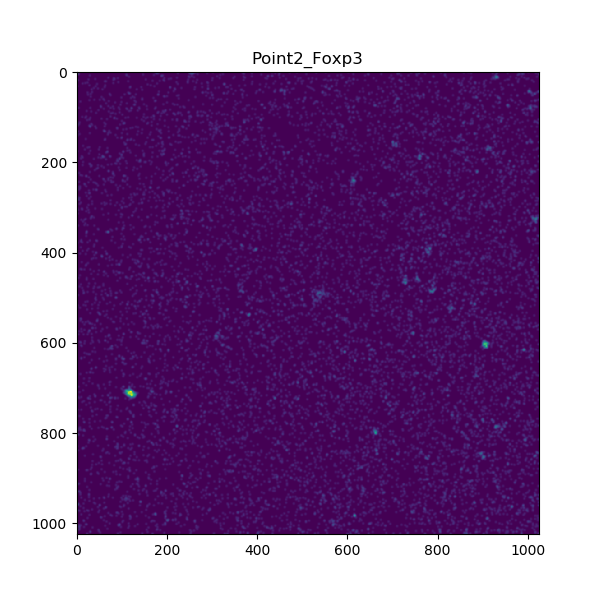

Text(0.5, 1.0, 'Point2_Foxp3')

In [120]:
idx = 5
marker = test_ds.source[idx]
x = test_ds.images[idx]

fig1 = plt.figure(figsize=(6,6))
plt.imshow(gaussian_filter(x[0,:,:],sigma=2))
plt.title(marker[0:-4])

<IPython.core.display.Javascript object>


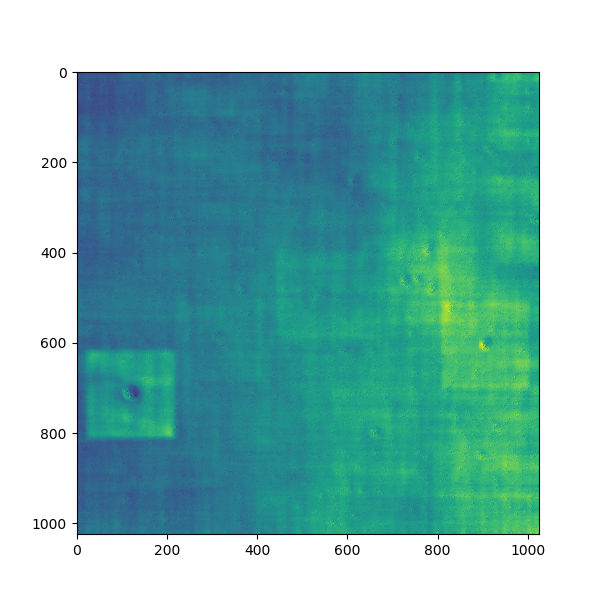

In [121]:
x = test_ds.images[idx].unsqueeze(0).cuda()
y = estimator.estimate(x)
z = denoiser.denoise(x, 1.4*y)

fig0 = plt.figure(figsize=(6,6))
plt.imshow(y[0,0,:,:].detach().cpu())



<IPython.core.display.Javascript object>


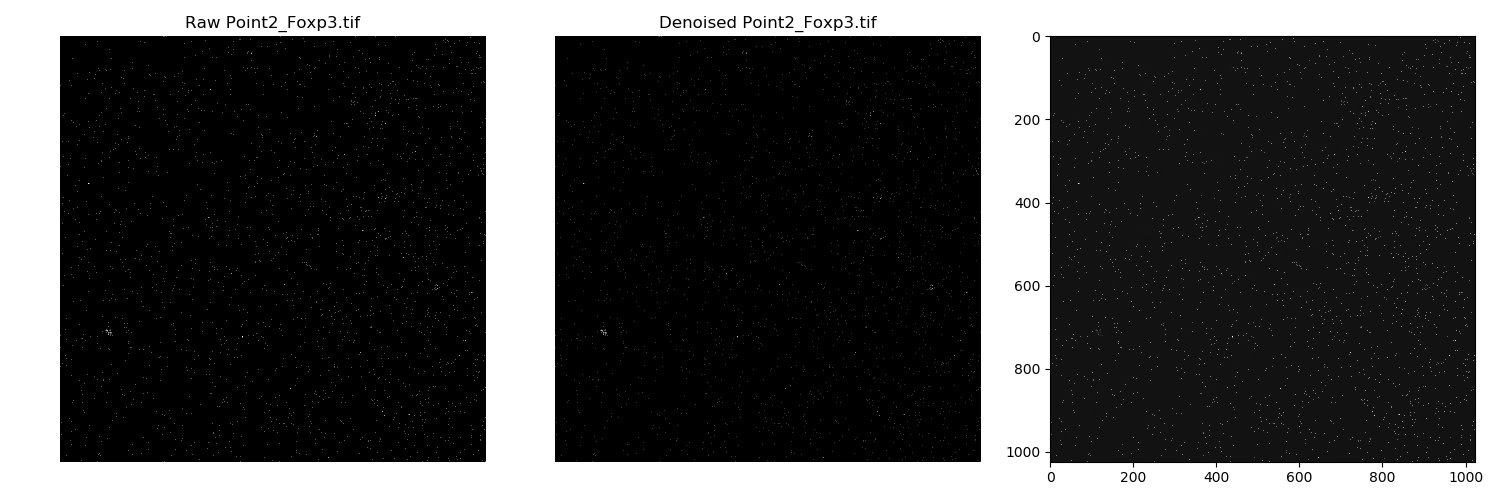

In [122]:
fig2 = plt.figure(figsize=(15,5))
sigma_val = 0
scale = 3
ax1 = plt.subplot(1,3,1)
plt.imshow(gaussian_filter(x[0,0,:,:].detach().cpu(), sigma=sigma_val), cmap='gray')
plt.title('Raw ' + marker)
plt.axis('off')
ax2 = plt.subplot(1,3,2, sharex=ax1, sharey=ax1)
z[z<0]=0
plt.imshow(gaussian_filter(z[0,0,:,:].detach().cpu(), sigma=sigma_val), cmap='gray')
plt.title('Denoised ' + marker)
plt.axis('off')
ax3 = plt.subplot(1,3,3, sharex=ax1, sharey=ax1)
plt.imshow(gaussian_filter(x[0,0,:,:].detach().cpu()-z[0,0,:,:].detach().cpu(), sigma=sigma_val), cmap='gray')
plt.tight_layout()